In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Every day we get different messages. There are different algorithm that are used to categorize those messages as ham and spam. In this analysis, I will try to predict whether or not the message is spam. I will use the dataset provided by UC Irvince, which you can find here: https://archive.ics.uci.edu/ml/datasets/sms+spam+collection.

###**Exploratory Data Analysis**

First I need to import the necessary packages.

In [ ]:
# Import the necessary packages, import the datasets and set the max rows to show to 100
import numpy as np
import pandas as pd
import nltk
import string
import re
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
# Import the dataset
df = pd.read_table('/content/drive/My Drive/NLP/SMSSpamCollection', header = None, encoding = 'utf-8')
# Note: The code above is the  direction to my google drive, so it can be different for you.
# Show all the columns and 100 rows
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 2)

Next, I will see how the dataset looks like, what are the variables, are there any missing values, and what is the shape of the dataset.

In [ ]:
# Check the first 5 rows and the shape of dataframe
print(df.head())
print(df.shape)

      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


In [ ]:
# Check the number of unique values in the dataframe
print(df.nunique())

0       2
1    5169
dtype: int64


In [ ]:
# Get info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       5572 non-null   object
 1   1       5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
# Check number of ham and spam mails
classes = df[0]
print(classes.value_counts())

ham     4825
spam     747
Name: 0, dtype: int64


Note: The number spam messages is relatively small, which means that if I take all the messages as ham, then I will have around 87% accuracy (number of ham)/(number of total) * 100.

To start the analysis, I need to convert ham and spam to 0 and 1 and drop the duplicates. The following functions perform all that operations.

In [ ]:
# Convert ham and spam to 0 and 1, drop the duplicate rows and reset the index
def convert(row):
  if row[0] == "ham":
    return 0
  else:
    return 1

df['spam'] = df.apply(convert, axis=1)
df = df.drop([0], axis=1)
# Drop the duplicates
df.drop_duplicates(inplace = True)
# Reset index
df = df.reset_index(drop=True)
print(df.shape)

(5169, 2)


After applying the function to the dataset, I dropped the duplicate rows and changed the indexes to start from 0 again. As I removed the duplicate rows, and the number of rows decreased from 5572 to 5169.

In [ ]:
# Check number of ham and spam mails
classes = df['spam']
print(classes.value_counts())

0    4516
1     653
Name: spam, dtype: int64


##**Text Preprocessing**

I need to remove https, email addresses, phone numbers, money signs, numbers, punctuations, white spaces between the words (if more than one), and leading and tailing white spaces. The reason is that I need to see if the occurance of email of phone number and not a specific email/phone number can indicate whether or not the email is spam. Also, I need to make all the words lowercase ("he" and "He" have the same meaning), remove the sropwords (is, which, this, etc) and normalize the lexicon ("car" and "cars" have the same meaning). 

In [ ]:
# Take the text column
text_messages = df[1]

In [ ]:
# Import the necessary libraries
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

To replace email address or phone numbers, I used regular expressions. I used the following website: http://regexlib.com/Search.aspx to get the necessary expressions. Below is a class, which includes all the function necessary to perform all the text celaning processes.

In [ ]:
# Create a class
class PreprocessText:    
    def __init__(self, language):
        self.Lemmatizer = WordNetLemmatizer() 
        self.stop_words = stopwords.words(language)
        
    def replace_emails(self, text):
        """This function takes test as an argument"""
        return re.sub(r'\S+@\S+', 'emailaddr', text)
    
    def replace_urls(self, text):
        return re.sub(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddr', text)
    
    def replace_money(self, text):
        return re.sub(r'£|\$', 'money', text)
    
    def replace_phone(self, text):
        return re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phone', text)
    
    def replace_number(self, text):
        return re.sub(r'\d+(\.\d+)?', 'number', text)
    
    def _remove_punctuation(self, text):
        return re.sub(r'[^\w\d\s]', ' ', text.lower())
    
    def preprocess_text(self, text, keep_emails = False, keep_urls = False, keep_money = False, keep_phone = False, keep_number = False):
        text = text
        if keep_emails == False:
            text = self.replace_emails(text)
        if keep_urls == False:
            text = self.replace_urls(text)
        if keep_money == False:
            text = self.replace_money(text)
        if keep_phone == False:
            text = self.replace_phone(text)
        if keep_number == False:
            text = self.replace_number(text)
        text = self._remove_punctuation(text)
        text = ' '.join(
        self.Lemmatizer.lemmatize(term) 
        for term in text.split()
        if term not in self.stop_words
        )
        return text

    def preprocess_data(self, data, keep_emails = False, keep_urls = False, keep_money = False, keep_phone = False, keep_number = False):
        assert(type(data) == list)
        processed_data = []
        for i in data:
            processed_data.append(self.preprocess_text(i, keep_emails = keep_emails, keep_urls = keep_emails, keep_money = keep_emails, keep_phone = keep_emails, keep_number = keep_emails))
        return processed_data
            

In [ ]:
# Clean the text
pt = PreprocessText(language = 'english')
text_messages = pd.Series(pt.preprocess_data(list(text_messages)))
text_messages.head()

0    go jurong point crazy available bugis n great ...
1                              ok lar joking wif u oni
2    free entry number wkly comp win fa cup final t...
3                  u dun say early hor u c already say
4                  nah think go usf life around though
dtype: object

Next, I will visualize the occurance of different words, to see which words are the most common in the text.

In [ ]:
# Import the necessary packages
nltk.download('punkt')
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


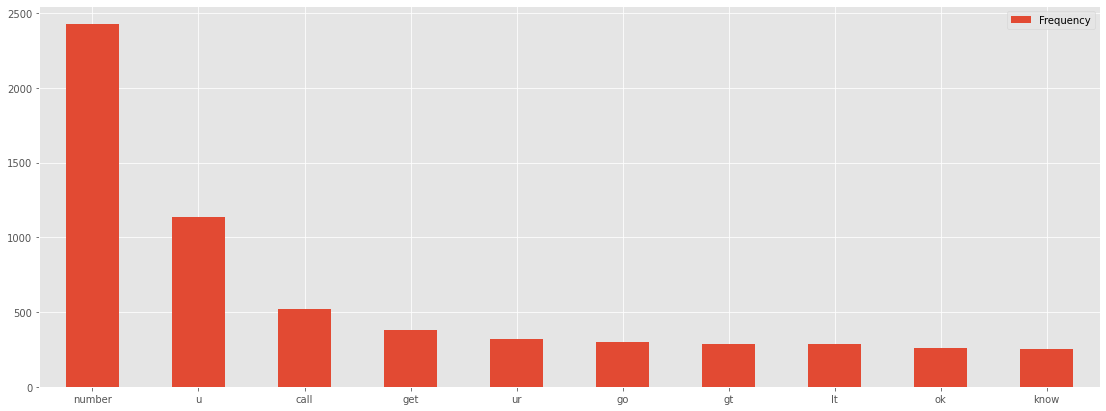

In [ ]:
# Plot the most common words
count = pd.DataFrame(pd.Series(' '.join(text_messages).split()).value_counts()[:10],
                    columns=['Frequency'])
matplotlib.style.use('ggplot')
count.plot.bar(rot=0, figsize = (19, 7))

##**Feature Engineering**

After cleaning the data, I need to perform feature engineering. First, I need to tokenize the data. I can tokenize not only each word or each sentence, but also pair of words. For example, bigram tokenization is when a pair of two words is taken as a token. The advantage of bigram tokenization is that it allows to capture also the importance of word pairs. I will do unigram and bigram tokenization, and then will calculate tf-idf statistics to see the frequency of each token in the text.

In [ ]:
# Import TFidfVectorizer to calculate tf-idf statistics. I use ngram_range as 1 and 2 to take unigram and bigram 
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
n_grams = vectorizer.fit_transform(text_messages)
# Check the shape of the final data
print(n_grams.shape)

(5169, 37891)


##**Build Models**

I will make different models to see which one is better for prediction. First, I will try SVM model. I will try different parameters and will use Bayesian Optimization method to get the best parameters.

In [ ]:
# Import the necessary packages
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
# Set X and y variables and split into train test 80/20
X = n_grams
y = df['spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

Now, I will perform Bayesian Optimization on the train dataset to find the best parameters.

In [ ]:
# Import Support Vector Classifier and find the best parameters
from sklearn.svm import SVC
def acc_model(params):
    clf = SVC(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'C': hp.uniform('C', 1,3),
    'kernel': hp.choice('kernel', ["linear", "poly", "rbf", "sigmoid"]),
    'gamma': hp.choice('gamma', ["scale", "auto"])}

best_svc = 0
best_params = []
def f(params):
    global best_svc
    acc = acc_model(params)
    if acc > best_svc:
        best_svc = acc
        best_params.append(params)
    print('The accuracy is {} and the best params are {}'.format(round(acc,3), params))
    return -acc

trials = Trials()
best_svc = fmin(f, param_space, algo=tpe.suggest, max_evals=30, trials=trials)

The accuracy is 0.978 and the best params are {'C': 2.4280295532009735, 'gamma': 'scale', 'kernel': 'linear'}
The accuracy is 0.967 and the best params are {'C': 2.3738745179808998, 'gamma': 'scale', 'kernel': 'rbf'}
The accuracy is 0.872 and the best params are {'C': 1.162419085542508, 'gamma': 'auto', 'kernel': 'sigmoid'}
The accuracy is 0.98 and the best params are {'C': 1.462123890380021, 'gamma': 'scale', 'kernel': 'sigmoid'}
The accuracy is 0.978 and the best params are {'C': 1.3937540482923148, 'gamma': 'auto', 'kernel': 'linear'}
The accuracy is 0.978 and the best params are {'C': 1.3201138932502459, 'gamma': 'auto', 'kernel': 'linear'}
The accuracy is 0.872 and the best params are {'C': 2.089999001228091, 'gamma': 'auto', 'kernel': 'rbf'}
The accuracy is 0.978 and the best params are {'C': 2.208615172769209, 'gamma': 'scale', 'kernel': 'linear'}
The accuracy is 0.916 and the best params are {'C': 1.5651592599504782, 'gamma': 'scale', 'kernel': 'poly'}
The accuracy is 0.978 and

In [ ]:
# Fit model on train dataset
from sklearn.svm import SVC
best_params = best_params[-1]
SVC = SVC(**best_params)
SVC1 = SVC.fit(X_train, y_train)
# Make the confustion matrix and calculate AUC score
SVC_pred = SVC1.predict(X_test)
print(confusion_matrix(y_test, SVC_pred))
print("Test AUC score for SVC is", roc_auc_score(y_test, SVC_pred))
print(classification_report(y_test, SVC_pred))

[[906   5]
 [ 19 104]]
Test AUC score for SVC is 0.9200199905401909
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       911
           1       0.95      0.85      0.90       123

    accuracy                           0.98      1034
   macro avg       0.97      0.92      0.94      1034
weighted avg       0.98      0.98      0.98      1034



With SVM I get around 98% accuracy and 0.92 AUC score. Note again that the data are not well balanced and there are 4516 ham and 653 spam emails, which means that by assigning all the emails as ham I would get 87% accuracy. From the confusion matrix we can see that we have mainly False Positive errors, which means that the model sometimes wrongly predicts the message is spam.

Next I will make Random Forest model.

In [ ]:
# Import Random Forest Classifier and find the best parameters
from sklearn.ensemble import RandomForestClassifier
def acc_model(params):
    clf = RandomForestClassifier(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'max_depth': hp.choice('max_depth', range(100,200)),
    'max_features': hp.choice('max_features', range(100,200)),
    'n_estimators': hp.choice('n_estimators', range(250,350)),
    'criterion': hp.choice('criterion', ["gini", "entropy"])
}

best_rf = 0
best_params_rf = []
def f(params):
    global best_rf
    acc = acc_model(params)
    if acc > best_rf:
      best_rf = acc
      best_params_rf.append(params)
    print('The accuracy is {} and the best params are {}'.format(round(acc,3), params))
    return -acc

trials = Trials()
best_rf = fmin(f, param_space, algo=tpe.suggest, max_evals=30, trials=trials)

The accuracy is 0.971 and the best params are {'criterion': 'gini', 'max_depth': 127, 'max_features': 142, 'n_estimators': 344}
The accuracy is 0.971 and the best params are {'criterion': 'gini', 'max_depth': 119, 'max_features': 172, 'n_estimators': 274}
The accuracy is 0.97 and the best params are {'criterion': 'entropy', 'max_depth': 128, 'max_features': 147, 'n_estimators': 331}
The accuracy is 0.971 and the best params are {'criterion': 'gini', 'max_depth': 121, 'max_features': 152, 'n_estimators': 293}
The accuracy is 0.973 and the best params are {'criterion': 'gini', 'max_depth': 108, 'max_features': 174, 'n_estimators': 299}
The accuracy is 0.971 and the best params are {'criterion': 'entropy', 'max_depth': 132, 'max_features': 180, 'n_estimators': 303}
The accuracy is 0.97 and the best params are {'criterion': 'gini', 'max_depth': 109, 'max_features': 140, 'n_estimators': 336}
The accuracy is 0.97 and the best params are {'criterion': 'entropy', 'max_depth': 110, 'max_feature

In [ ]:
# Fit model on train dataset
from sklearn.ensemble import RandomForestClassifier
best_params_rf = best_params_rf[-1]
RandomForestClassifier = RandomForestClassifier(**best_params_rf)
RandomForestClassifier1 = RandomForestClassifier.fit(X_train, y_train)
# Make the confustion matrix and calculate AUC score
RF_pred = RandomForestClassifier1.predict(X_test)
print(confusion_matrix(y_test, RF_pred))
print("Test AUC score for RF is", roc_auc_score(y_test, RF_pred))
print(classification_report(y_test, RF_pred))

[[911   0]
 [ 30  93]]
Test AUC score for RF is 0.8780487804878049
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       911
           1       1.00      0.76      0.86       123

    accuracy                           0.97      1034
   macro avg       0.98      0.88      0.92      1034
weighted avg       0.97      0.97      0.97      1034



I used Bayesian Optimization for RF as well and got 97% accuracy and 0.88 AUC score (lower than SVM). By looking at the confusion matrix you can see that again the False Positives are the main causes of errors. Note that even though the number of False Positives has increased, but the number of False Negatives is now zero. Next I will try a relatively simple, Logistic Regression model.

In [ ]:
# Import the package
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0)

In [ ]:
# Fit model on train dataset
LR1 = LR.fit(X_train, y_train)
# Make the confustion matrix and calculate AUC score
LR_pred = LR.predict(X_test)
print(confusion_matrix(y_test, LR_pred))
print("Test AUC score for LR is", roc_auc_score(y_test, LR_pred))
print(classification_report(y_test, LR_pred))

[[907   4]
 [ 51  72]]
Test AUC score for LR is 0.7904875371475998
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       911
           1       0.95      0.59      0.72       123

    accuracy                           0.95      1034
   macro avg       0.95      0.79      0.85      1034
weighted avg       0.95      0.95      0.94      1034



As you can see, a realitvely simple model does not predict well, and next I will try more advance model: XGBoost.

In [ ]:
# Import XGBoost and find the best parameters
import xgboost as xgb
xgbm = xgb.XGBClassifier
def acc_model(params):
    clf = xgbm(**params)
    return cross_val_score(clf, X_train, y_train).mean()

param_space = {
    'learning rate': hp.quniform('learning rate', 0.001, 0.1, 0.05),
    'n_estimators': hp.choice('n_estimators', range(200, 400)),
    'subsample': hp.quniform('subsample', 0, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.05),
    'reg_alpha': hp.choice('reg_alpha', [0.001, 0.01, 0.1])}

best_xgb = 0
best_params_xgb = []
def f(params):
    global best_xgb
    acc = acc_model(params)
    if acc > best_xgb:
      best_xgb = acc
      best_params_xgb.append(params)
    print('The accuracy is {} and the best params are {}'.format(round(acc,3), params))
    return -acc 

trials = Trials()
best_xgb = fmin(f, param_space, algo=tpe.suggest, max_evals=30, trials=trials)

The accuracy is 0.872 and the best params are {'colsample_bytree': 0.8500000000000001, 'learning rate': 0.1, 'n_estimators': 334, 'reg_alpha': 0.1, 'subsample': 0.0}
The accuracy is 0.978 and the best params are {'colsample_bytree': 0.75, 'learning rate': 0.1, 'n_estimators': 328, 'reg_alpha': 0.1, 'subsample': 0.8}
The accuracy is 0.872 and the best params are {'colsample_bytree': 0.9500000000000001, 'learning rate': 0.05, 'n_estimators': 291, 'reg_alpha': 0.001, 'subsample': 0.0}
The accuracy is 0.977 and the best params are {'colsample_bytree': 0.15000000000000002, 'learning rate': 0.05, 'n_estimators': 373, 'reg_alpha': 0.001, 'subsample': 0.30000000000000004}
The accuracy is 0.975 and the best params are {'colsample_bytree': 0.4, 'learning rate': 0.05, 'n_estimators': 213, 'reg_alpha': 0.01, 'subsample': 0.2}
The accuracy is 0.974 and the best params are {'colsample_bytree': 0.30000000000000004, 'learning rate': 0.0, 'n_estimators': 211, 'reg_alpha': 0.001, 'subsample': 0.2}
The a

In [ ]:
# Fit model on train dataset
xgb = xgb.XGBClassifier
xgb = xgb(params = best_params_xgb[-1])
xgb1 = xgb.fit(X_train, y_train)
xgb_pred = xgb1.predict(X_test)
print(confusion_matrix(y_test, xgb_pred))
print("Test AUC score for XGBoost is", roc_auc_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

[[909   2]
 [ 26  97]]
Test AUC score for XGBoost is 0.8932112482485965
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       911
           1       0.98      0.79      0.87       123

    accuracy                           0.97      1034
   macro avg       0.98      0.89      0.93      1034
weighted avg       0.97      0.97      0.97      1034



In the end, I will visualize all the ROC curves. Below is the code necessary to make the plot.

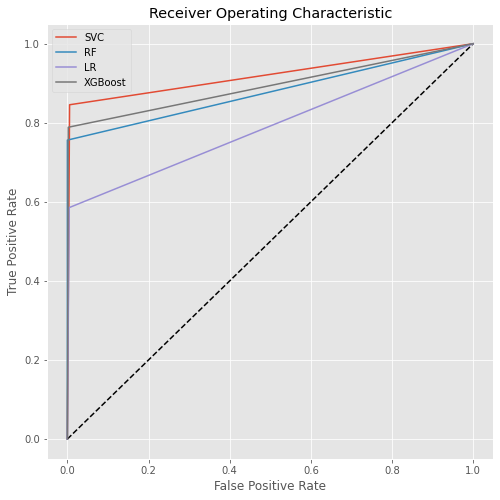

In [ ]:
# Visualize ROC curve for all the models
# Define the parameters
svc_fpr, svc_tpr, _ = roc_curve(y_test, SVC_pred)
rf_fpr, rf_tpr, _ = roc_curve(y_test, RF_pred)
lr_fpr, lr_tpr, _ = roc_curve(y_test, LR_pred)
xgb_fpr, xgp_tpr, _ = roc_curve(y_test, xgb_pred)
# Make the plot
plt.figure(figsize=(8,8))
plt.plot([0,1],[0,1], 'k--')
plt.plot(svc_fpr, svc_tpr, label= "SVC")
plt.plot(rf_fpr, rf_tpr, label= "RF")
plt.plot(lr_fpr, lr_tpr, label= "LR")
plt.plot(xgb_fpr, xgp_tpr, label= "XGBoost")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

Overall, after trying XGBoost, Logistic Regression, Random Forest, and SVM, I found that SVM model has the highest accuracy (around 98%). Nore also that the tree based models (XGBoost and RF) were performing well as well, and had accuracy of 97%. The simple model, Logistic Regression, was not good for prediciont as it had relatively low accuracy (95%) and AUC (0.89) scores. The errors are associated mainly with False Positives, when the algorithm predicts messages to be spam, even though they are not. The reason why SVM performs better than XGBoost can be the small number of observations (5,169 in total).